In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
sys.path.append('../spock/')
from modelfitting import ROC_curve
try:
    plt.style.use('paper')
except:
    pass
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics
from xgboost import XGBClassifier
%matplotlib inline

sys.path.append('../../PlanetSysSurvivalTime/modules/')
import survivaltime as st

In [2]:
df = pd.read_csv('../training_data/resonant/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)
labels = pd.read_csv('../training_data/resonant/additional_featuresNorbits10000.0Nout80trio/labels.csv', index_col=0)
df.tail()

,EMfracstdnear,EPstdnear,AMDfracnear,MMRstrengthnear,betanear,AMDcritnear,EMcrossnear,jnear,knear,EMfracstdfar,...,Z07Stable_avg,Z07Stable_worstpair,deltaQ11inner,deltaQ11outer,deltaQ11avg,Q11log_instability_time_inner,Q11log_instability_time_outer,Q11log_instability_time_avg,Q11Stable_avg,Q11Stable_worstpair
113538,0.049940,0.016289,275.125979,0.608276,3.120145,8.772371e-09,0.082222,9.0,1.0,0.031330,...,False,False,0.399119,0.075976,0.237547,9.302344,4.024534,7.162971,False,False
113539,0.016063,0.002925,0.538688,0.252494,10.619708,1.357430e-07,0.251338,7.0,2.0,0.002159,...,False,False,0.200855,0.214344,0.207600,8.439196,8.151632,8.496414,False,False
113540,0.027693,0.001458,2.059439,0.659321,2.798741,4.870298e-07,0.131799,6.0,1.0,0.067472,...,False,False,0.116451,0.268291,0.192371,3.475108,9.486868,6.047256,False,False
113541,0.090838,0.010214,2.076593,1.436775,5.057940,1.805446e-06,0.209454,4.0,1.0,0.102280,...,False,False,0.173181,0.283192,0.228186,5.622301,8.180472,7.329276,False,False
113542,0.129844,0.040866,8.958517,0.052695,6.216486,5.531512e-07,0.182523,9.0,2.0,0.050120,...,False,False,0.154350,0.300935,0.227643,6.483611,9.280696,8.194068,False,False


In [3]:
masses = pd.read_csv('../training_data/resonant/massratios.csv', index_col=0)
pratios = pd.read_csv('../paper_plots/resPratios.csv', index_col=0)
pratios.tail()

,runstring,instability_time,shadow_instability_time,Stable,Pratio21,Pratio32,beta12,beta23
113538,9045377.bin,6.990387e+05,8.267916e+05,False,2.146925,1.125825,22.762855,4.500139
113539,9045378.bin,3.075749e+08,6.576003e+08,False,1.399777,1.435985,15.316273,14.379617
113540,9045380.bin,1.193822e+07,3.363291e+07,False,1.204069,1.597688,4.036607,21.136880
113541,9045382.bin,2.064407e+08,4.316851e+07,False,1.330065,1.647766,7.294859,15.323072
113542,9045383.bin,2.266066e+04,2.228425e+04,False,1.285910,1.710886,8.965751,20.618763


In [4]:
df['m1'] = masses['m1']
df['m2'] = masses['m2']
df['m3'] = masses['m3']
df['Pratio21'] = pratios['Pratio21']
df['Pratio32'] = pratios['Pratio32']

In [6]:
def petit(row):
    row['P20tpred'] = st.Tsurv(1/row['Pratio21'], 1/row['Pratio32'], [row['m1'], row['m2'], row['m3']], m0=1, res=False, fudge=1)
    row['P20Stable'] = row['P20tpred'] >= 1e9
    return row

In [7]:
%%time
df = df.apply(petit, axis=1)

CPU times: user 2min 57s, sys: 4.39 s, total: 3min 1s
Wall time: 2min 54s


# Petit 2020

In [8]:
TPRP20 = (labels['Stable'] & df['P20Stable']).sum()/labels['Stable'].sum()
TPRP20

0.9947043915724174

In [9]:
FPRP20 = ((~labels['Stable']) & df['P20Stable']).sum()/(~labels['Stable']).sum()
FPRP20

0.9070557711294285

# Zhou 2007 avg

In [10]:
TPRZ07 = (labels['Stable'] & df['Z07Stable_avg']).sum()/labels['Stable'].sum()
TPRZ07

0.13776147066611188

In [11]:
FPRZ07 = ((~labels['Stable']) & df['Z07Stable_avg']).sum()/(~labels['Stable']).sum()
FPRZ07

0.022570201823066148

# Zhou 2007 worst pair

In [12]:
TPR = (labels['Stable'] & df['Z07Stable_worstpair']).sum()/labels['Stable'].sum()
TPR

0.04660135416272648

In [13]:
FPR = ((~labels['Stable']) & df['Z07Stable_worstpair']).sum()/(~labels['Stable']).sum()
FPR

0.004018092898307809

# Quillen 2011 average

In [14]:
TPRQ11 = (labels['Stable'] & df['Q11Stable_avg']).sum()/labels['Stable'].sum()
TPRQ11

0.24306842682603927

In [15]:
FPRQ11 = ((~labels['Stable']) & df['Q11Stable_avg']).sum()/(~labels['Stable']).sum()
FPRQ11

0.07800840355429017

# Quillen 2011 worst pair

In [16]:
TPR = (labels['Stable'] & df['Q11Stable_worstpair']).sum()/labels['Stable'].sum()
TPR

0.1020917653288951

In [17]:
FPR = ((~labels['Stable']) & df['Q11Stable_worstpair']).sum()/(~labels['Stable']).sum()
FPR

0.037930796960025714

# How many total stable?

In [58]:
df['Q11Stable_avg'].sum()/labels.shape[0]

0.11644046748808821

In [51]:
df['Z07Stable_avg'].sum()/labels.shape[0]

0.049390979628863074

In [18]:
df['P20Stable'].sum()/labels.shape[0]

0.9274636040971262

In [52]:
labels['Stable'].sum()/labels.shape[0]

0.23283689879605082

# SPOCK comparisons

In [34]:
name='SPOCK'
filename='featureclassifier'
model = XGBClassifier()
model.load_model('../spock/models/'+filename+'.json')
testingdatafolder = '../training_data/resonant/featuresNorbits10000.0Nout80trio/'  

dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
features = dataset.columns.values

Nrows = int(0.8*dataset.shape[0])
y = labels['Stable'].iloc[Nrows:]
X = dataset[features].iloc[Nrows:]
preds = model.predict_proba(X)[:,1]
fpr, tpr, ROCthresholds = roc_curve(y, preds)
roc_auc = metrics.roc_auc_score(y, preds)

In [37]:
def spockTPR(FPR):
    threshindex = np.where(fpr > FPR)[0][0]
    pthresh = ROCthresholds[threshindex]
    stabs = preds > pthresh
    TPR = (y & stabs).sum()/y.sum()
    print('At an FPR of {0:.4f}, SPOCK has a TPR of {1:.3f}'.format(FPR, TPR))
    
spockTPR(FPRQ11)
spockTPR(FPRZ07)
spockTPR(FPRP20)

At an FPR of 0.0780, SPOCK has a TPR of 0.808
At an FPR of 0.0226, SPOCK has a TPR of 0.569
At an FPR of 0.9071, SPOCK has a TPR of 1.000


In [38]:
def spockFPR(TPR):
    threshindex = np.where(tpr > TPR)[0][0]
    pthresh = ROCthresholds[threshindex]
    stabs = preds > pthresh
    FPR = (~y & stabs).sum()/(~y).sum()
    print('At a TPR of {0:.3f}, SPOCK has an FPR of {1:.4f}'.format(TPR, FPR))
    
spockFPR(TPRQ11)
spockFPR(TPRZ07)
spockFPR(TPRP20)

At a TPR of 0.243, SPOCK has an FPR of 0.0030
At a TPR of 0.138, SPOCK has an FPR of 0.0007
At a TPR of 0.995, SPOCK has an FPR of 0.4356


# Models trained on resonant dataset

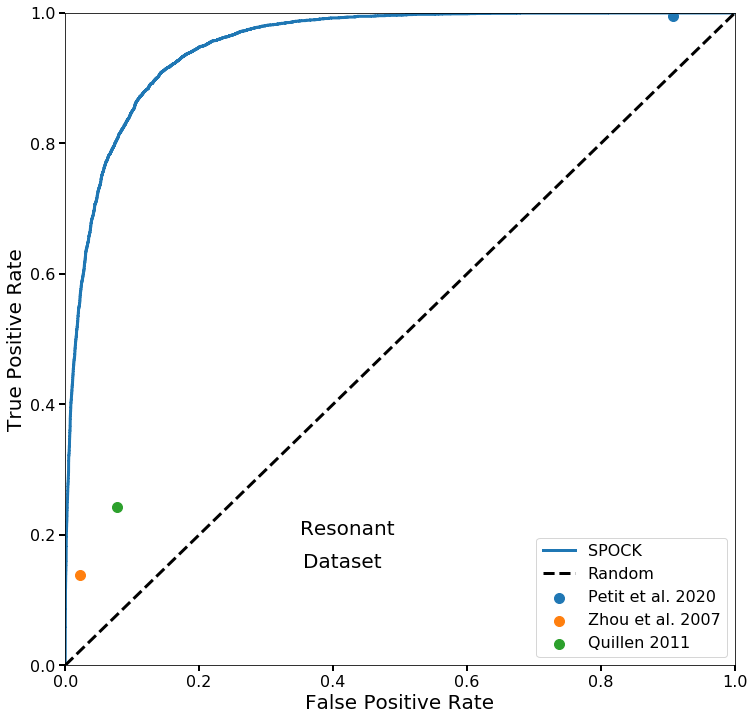

In [43]:
FPRthresh=0.1
TPRthresh=0.9
models = {'SPOCK':'spock', 'Hill':'hill'}
featuresdic = {'SPOCK':None, 'MEGNO':['MEGNO'], 'Hill':['betanear', 'betafar']}

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')


#print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]), 
#"Thresh = {0:.3f}".format(ROCthresholds[tprthreshindex]),  "TPR = {0:.3f}".format(tpr[tprthreshindex]), "FPR = {0:.3f}".format(fpr[tprthreshindex]))
ax.plot(fpr, tpr, label='{0}'.format('SPOCK'))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.35, 0.2, "Resonant", fontsize=20)
ax.text(0.355, 0.15, "Dataset", fontsize=20)
ax.scatter(FPRP20, TPRP20, label='Petit et al. 2020')
ax.scatter(FPRZ07, TPRZ07, label='Zhou et al. 2007')
ax.scatter(FPRQ11, TPRQ11, label='Quillen 2011')

ax.legend()
#fig.savefig('QuillenZhouComparison.pdf', bbox_inches='tight')
fig.savefig